In [ ]:
pip install tensorflow keras scikit-learn pandas


In [ ]:
import numpy as np
import pandas as pd
import ast

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
def load_and_preprocess_train(train_csv_path):
    """
    Đọc file train.csv, chuyển đổi cột 'bug' thành nhãn 0 (clean) và 1 (buggy),
    parse cột 'int_vector_fixed' (dạng chuỗi) thành list và tạo numpy array.
    """
    df = pd.read_csv(train_csv_path)
    df['label'] = df['bug'].apply(lambda x: 1 if x == 'buggy' else 0)
    df['int_vector_fixed'] = df['int_vector_fixed'].apply(lambda x: ast.literal_eval(x))
    X = np.array(df['int_vector_fixed'].tolist())
    y = df['label'].values
    return X, y

def load_and_preprocess_test(test_csv_path):
    """
    Đọc file test.csv, parse cột 'int_vector_fixed' thành list và tạo numpy array.
    Nếu test.csv có cột 'bug' (nhãn), chuyển đổi tương tự.
    """
    df = pd.read_csv(test_csv_path)
    df['label'] = df['bug'].apply(lambda x: 1 if x == 'buggy' else 0)

    df['int_vector_fixed'] = df['int_vector_fixed'].apply(lambda x: ast.literal_eval(x))
    X = np.array(df['int_vector_fixed'].tolist())
    y = df['label'].values
    return X, y

In [39]:
train_csv_path = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\train.csv"
ant_csv = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\ant-1.6.csv"

X, y = load_and_preprocess_train(train_csv_path)
X

array([[ 379, 1576, 1899, ...,    0,    0,    0],
       [ 342, 2640,  440, ...,    0,    0,    0],
       [  73,  509, 2398, ...,    0,    0,    0],
       ...,
       [ 517,  911,    3, ...,    0,    0,    0],
       [ 412,    3, 2417, ...,    0,    0,    0],
       [  22, 1439,  231, ..., 1685,    0,    0]])

In [ ]:
def build_cnn_concat_model(max_len, vocab_size, num_trad_features, embedding_dim=30):
    """
    1) input_tokens (chuỗi ID) -> Embedding -> Conv1D -> GlobalMaxPooling1D -> Dense
    2) input_trad (các cột wmc, noc, cbo, …)
    Sau đó concat và đưa qua lớp Dense cuối với activation='sigmoid'.
    """
    input_tokens = Input(shape=(max_len,), name="input_tokens")
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_tokens)
    x = Conv1D(filters=100, kernel_size=5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    
    input_trad = Input(shape=(num_trad_features,), name="input_trad")    
    merged = Concatenate()([x, input_trad])
    merged = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[input_tokens, input_trad], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
    return model


In [ ]:
train_csv_path = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\train.csv"
test_csv_path  = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\test.csv"


trad_csv_path = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\trad_feature1.6.csv"
trad_test_csv_path = r"C:\Users\Acer\Desktop\2024\lab\DP-CNN\trad_feature1.7.csv"

X_tokens_train, y_train = load_and_preprocess_train(train_csv_path)

df_train = pd.read_csv(train_csv_path)

df_trad_train = pd.read_csv(trad_csv_path)

df_merged_train = pd.merge(df_train, df_trad_train, on='name', how='inner')

trad_cols = ['wmc','noc','cbo','rfc','lcom','ca','ce','npm','loc','dam','moa','mfa','cam','ic','cbm','amc','max_cc','avg_cc']
trad_cols = [c for c in trad_cols if c in df_merged_train.columns]

X_trad_train = df_merged_train[trad_cols].values


df_merged_train['int_vector_fixed'] = df_merged_train['int_vector_fixed'].apply(lambda x: ast.literal_eval(x))
X_tokens_train = np.array(df_merged_train['int_vector_fixed'].tolist())
y_train = df_merged_train['bug'].apply(lambda x: 1 if x == 'buggy' else 0).values

max_len = X_tokens_train.shape[1]
vocab_size = int(X_tokens_train.max()) + 1
num_trad_features = len(trad_cols)

X_tok_tr, X_tok_val, X_trad_tr, X_trad_val, y_tr, y_val = train_test_split(
    X_tokens_train, X_trad_train, y_train, test_size=0.2, random_state=42
)

model = build_cnn_concat_model(max_len, vocab_size, num_trad_features, embedding_dim=30)

history = model.fit(
    [X_tok_tr, X_trad_tr], y_tr,
    validation_data=([X_tok_val, X_trad_val], y_val),
    epochs=10, batch_size=32
)

y_val_pred_prob = model.predict([X_tok_val, X_trad_val])
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
print(f"Validation: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

X_tokens_test, y_test = load_and_preprocess_test(test_csv_path)
df_test = pd.read_csv(test_csv_path)
df_trad_test = pd.read_csv(trad_test_csv_path)
df_merged_test = pd.merge(df_test, df_trad_test, on='name', how='inner')

df_merged_test['int_vector_fixed'] = df_merged_test['int_vector_fixed'].apply(lambda x: ast.literal_eval(x))
X_tokens_test = np.array(df_merged_test['int_vector_fixed'].tolist())
y_test = df_merged_test['bug'].apply(lambda x: 1 if x == 'buggy' else 0).values
X_trad_test = df_merged_test[trad_cols].values

y_test_pred_prob = model.predict([X_tokens_test, X_trad_test])
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

prec_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f"Test: Precision={prec_test:.4f}, Recall={rec_test:.4f}, F1={f1_test:.4f}")

Epoch 1/10
12/12 [==============================] - 1s 32ms/step - loss: 4.4453 - accuracy: 0.4504 - val_loss: 3.2401 - val_accuracy: 0.4719
Epoch 2/10
12/12 [==============================] - 0s 20ms/step - loss: 2.3715 - accuracy: 0.5949 - val_loss: 1.5436 - val_accuracy: 0.6517
Epoch 3/10
12/12 [==============================] - 0s 17ms/step - loss: 1.4753 - accuracy: 0.7082 - val_loss: 1.1953 - val_accuracy: 0.6854
Epoch 4/10
12/12 [==============================] - 0s 15ms/step - loss: 1.1686 - accuracy: 0.7167 - val_loss: 0.9414 - val_accuracy: 0.6966
Epoch 5/10
12/12 [==============================] - 0s 18ms/step - loss: 0.8978 - accuracy: 0.7649 - val_loss: 1.0534 - val_accuracy: 0.6292
Epoch 6/10
12/12 [==============================] - 0s 21ms/step - loss: 0.7522 - accuracy: 0.7762 - val_loss: 0.8095 - val_accuracy: 0.7079
Epoch 7/10
12/12 [==============================] - 0s 23ms/step - loss: 0.5816 - accuracy: 0.7989 - val_loss: 0.6647 - val_accuracy: 0.6854
Epoch 8/10
12

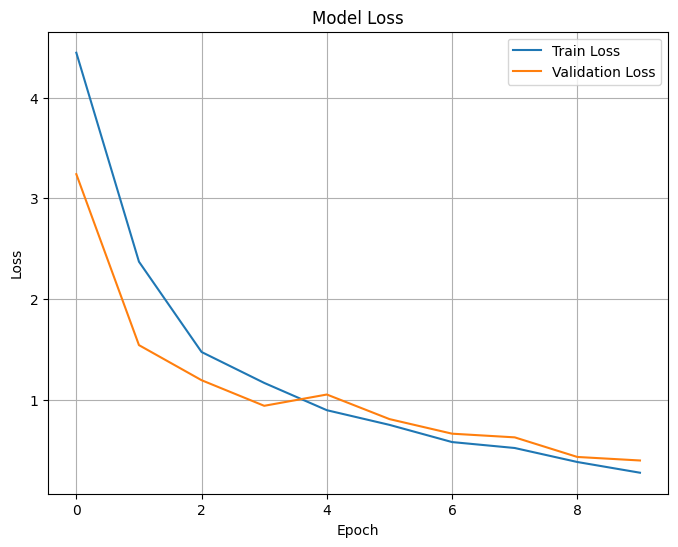

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()